# Language Binding in R with JuliaCall
---

**Gregory Farage, Śaunak Sen**    

    gfarage@uthsc.edu / sen@uthsc.edu
    Division of Biostatistics
    Department of Preventive Medicine
    University of Tennessee Health Science Center
    Memphis, TN

`JuliaCall` is a package that enables the integration of Julia language into R programming. With `JuliaCall`, users can execute Julia commands and functions within R, utilizing Julia's high-performance computing capabilities while still working within the familiar R environment. The package provides seamless communication between the two languages, allowing for data to be passed between R and Julia with ease. `JuliaCall` also provides for the installation of Julia packages from within R, making it a convenient tool for those looking to leverage the power of Julia while still utilizing R as their primary programming language.


*References for this notebook:*
* [JuliaCall: Integrating R and Julia by Hans W. Borchers](https://hwborchers.github.io/)
* [JuliaCall.jl](https://cran.r-project.org/web/packages/JuliaCall/index.html)

### Outline of this notebook

- Calling python built-in function 
- Calling python hand-written function 
- Importing python libraries
- Calling R built-in function
- Calling R hand-written function

`JuliaCall` offers a valuable solution for those seeking to take advantage of the benefits of both R and Julia in their data analysis and scientific computing projects.

## Example choice

Let's use the `sum` function as an example to understand how calling mechanisms work.   

The function `sum(x)` can computes the sum of all elements in an array `x` of length $n$:
$$
\mathrm{sum}(x) = \sum_{i=1}^n x_i.
$$

Generate a vector of random numbers

In [1]:
a <- runif(n=10^3, min=0, max=1)

The expected value is 500, since the vector `a` has a uniform distribution on [0,1) with each entry having a mean of 0.5.

In [2]:
sum(a)

[1] 487.4091

## JuliaCall first initialization

In [3]:
library(JuliaCall)
julia_setup() # Do initial setup for the JuliaCall package.

Julia version 1.8.5 at location C:\Users\farag\AppData\Local\Programs\JULIA-~1.5\bin will be used.

Loading setup script for JuliaCall...

Finish loading setup script for JuliaCall.



We can specify the path to a specific Julia version in the `julia_setup()` function by providing it as an option or argument. The code below illustrates how to initiate a Julia installation from a different directory.   
```R
> julia_setup(JULIA_HOME = "~/Softwares/julia/julia-1.8.5/bin/")
```

## Calling Julia's built-in `sum` 

In this example, the vector `a` is passed as an argument to the `sum` function in Julia. The argument `a` is first converted from R to a Julia object, and then the sum operation is performed on it. The resulting value is then returned back to R as an R object, which can be assigned to a variable. Notably,in this implementation, the variable `a` is NOT generated within the Julia environment.

In [4]:
julia_call("sum", a)

[1] 487.4091

To convert an R object, such as a number, vector, or matrix, into a Julia object and assign it to a variable name, the `julia_assign()` command must be used. The resulting variable can then be used in other Julia commands.

First let see if the variable exist in Julia:

In [5]:
julia_exists("name_var_in_julia")

[1] FALSE

In [6]:
julia_assign("name_var_in_julia", a)

Now, let's confirm that the variable named "name_var_in_julia" exists:

In [7]:
julia_exists("name_var_in_julia")

[1] TRUE

## Calling hand-written Julia `sum` function 


#### Loading local Julia code
In this instance, we created a Julia script called *julia_sum.jl* to process the `sum` function, which we then import into R via `JuliaCall`. This method permits us to load the code locally within R.

_filename: julia_sum.jl_

```julia
function jl_sum(R)
    s = 0.0
    for r in R
        s += r
    end
    return s
end
```

We use the `julia_source()` function to source our Julia code file.

In [8]:
julia_source("julia_sum.jl")

Let's verify that our function `jl_sum()` is defined in Julia: 

In [9]:
julia_exists("jl_sum")

[1] TRUE

To apply our new Julia sum function, `jl_sum()`, and save the result we can just use `julia_call()` such as:

In [10]:
result <- julia_call("jl_sum", a)
result

[1] 487.4091

#### Wrapping Julia code in R

Another option consist in writting the string containing a Julia expression/function  and wrap it into the R function `julia_command()`:

In [11]:
julia_command(
    "function jl_sum2(R)
        s = 0.0
        for r in R
            s += r
        end
        return s
    end"
)

jl_sum2 (generic function with 1 method)

Simlarly, we can obtain our result with `julia_call()`:

In [12]:
julia_call("jl_sum2", a)

[1] 487.4091

Notice that the output of a `julia_command()` corresponds to the output we would get in Julia. The function `julia_eval()` returns the output in R. Let's try a simple example:

Julia's output:

In [13]:
julia_command("typeof(name_var_in_julia)")

Vector{Float64} (alias for Array{Float64, 1})

R's output:

In [14]:
julia_eval("typeof(name_var_in_julia)")

Julia Object of type DataType.
Vector{Float64}

## Transfering data between Julia and R 

To transfer data between both languages, `JuliaCall.jl` provides two functions: `julia_assign()` and `julia_evaluate()`.

* The `julia_evaluate()` function is used to transfer data from Julia to R. 
* The `julia_assign()` function is used to transfer data from R to Julia. 

In the next example, we demonstrate how to tranfer data between R and Julia.
For this demonstration, we use a small dataset, which is based on a genetic study conducted on Arabidopsis thaliana, sourced from [Ågren et. al. (2013) via John Lovell](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876199/). The phenotype dataset comprises a group of Arabidopsis recombinant inbred lines that were obtained from a cross between two parents hailing from Italy and Sweden. These lines were cultivated in Italy and Sweden over a span of three years, from 2009 to 2011. The phenotype, which is an indicator of fitness, is the average number of seeds per plant for each line. In addition, we possess the genotype data for the FLC (Flowering Time C) locus.

Column names:

- id: ID of RI line (first two are the parents)
- it09: Italy 2009
- it10: Italy 2010
- it11: Italy 2011
- sw09: Sweden 2009
- sw10: Sweden 2010
- sw11: Sweden 2011
- flc: Flowering time locus (C) genotype

Let's load the necessary packages to read the data:

In [15]:
julia_command("using DataFrames, CSV" )

If a package is not found, we can install it using the function `julia_install_package_if_needed()`, which takes the string of the package's name as argument.

In [36]:
# to install package
# julia_install_package_if_needed("DataFrames")

As shown in the previous section, we can transfer data from R to Julia using `julia_assign()`. For example, we can transfer a string URL to Julia and store the information in a variable named `agrenURL`.

In [19]:
julia_assign("agrenURL", 
             "https://raw.githubusercontent.com/sens/smalldata/master/arabidopsis/agren2013.csv")

Let's read and store our dataframe into `agren` in Julia. 

In [31]:
julia_command(
    paste("agren = CSV.read(download(agrenURL),DataFrame, missingstring=\"NA\");",
    "agren = dropmissing(agren, disallowmissing=true);")
)

Now, we transfer a subset of our dataframe from Julia to R by using the function `julia_eval`.  

In [39]:
agrenFit <- julia_eval("agren[:,[1,2,3,4,5,6]]")

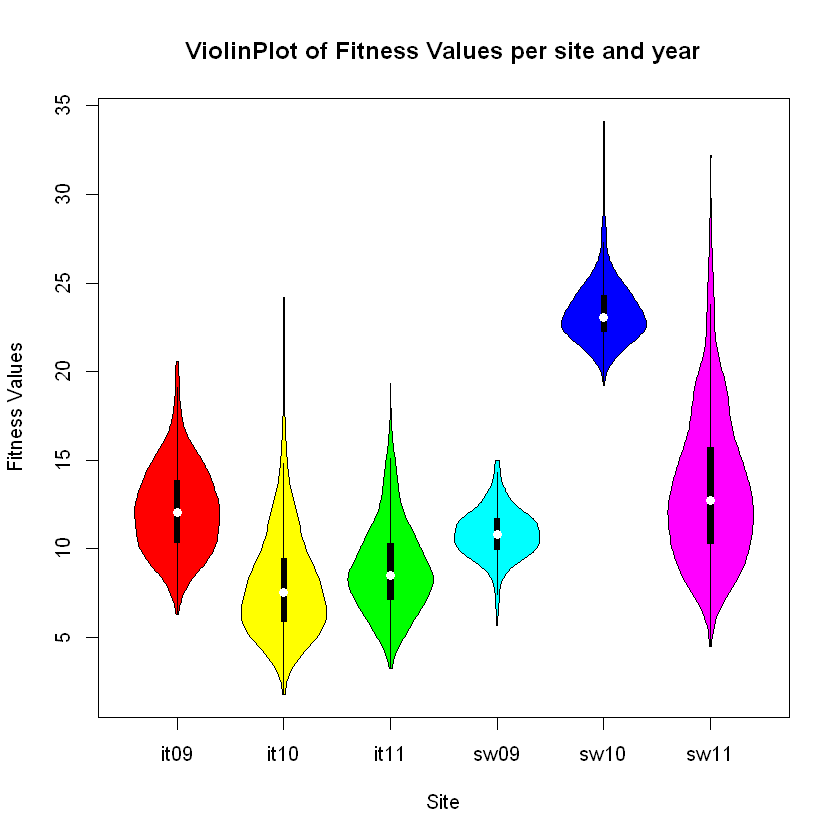

In [35]:
vioplot::vioplot(agrenFit, 
            names=names(agrenFit), 
            main = "ViolinPlot of Fitness Values per site and year", 
            xlab ="Site", 
            ylab =  "Fitness Values",
            col = rainbow(6))

## Summary

* JuliaCall provides access to Julia's high-performance computing capabilities, which can be useful for tasks that require intensive numerical computations.

* Access to Julia's packages.

* JuliaCall makes it easy to integrate Julia code into R programs, allowing users to combine the strengths of both languages in a single workflow.

* Interoperability: JuliaCall allows for seamless interoperability between R and Julia, enabling users to easily pass data and objects between the two languages.



In [3]:
sessionInfo()

R version 4.2.2 Patched (2022-11-10 r83330)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] vioplot_0.4.0 zoo_1.8-11    sm_2.2-5.7.1 

loaded via a namespace (and not attached):
 [1] lattice_0.20-45 fansi_1.0.3     crayon_1.5.2    digest_0.6.31  
 [5] utf8_1.2.2      IRdisplay_1.1   grid_4.2.2      repr_1.1.4     
 [9] lifecycle_1.0.3 js

## Exercise: using `julia_call` package in R

If you are an extensive R user and are not ready to fully switch to Julia, but still want to experience some features in Julia, such as using some Julia packages for your data analysis, this exercise would be particularly of your interests. 

For this exercise, we would use the Julia package `MatrixLM.jl`, a fast application of fitting multivariate linear models in Julia. We will fit the model:

$$Y = XBZ^T+E
$$

where 

- $Y$ is the multivariate response of dimension $n \times m$
- $X$ is the design matrix of row covariates of dimension $n \times p$
- $Z$ is the design matrix of column covariates of dimension $m \times q$
- $B$ is the matrix of interative effects of row and column covariates; it has dimension $p \times q$
- $E$ is the $n \times m$ matrix of normal noises.


We will be simulating data using R code, and use `MatrixLM.jl`

The goal of this exercise is mainly to familiarize you with the `R/julia_call` functionalities, by which you can easily utilize some additional features in Julia running Julia packages in the backend, while still staying in the R interface.

#### Ex.1: Simulate data in R

Set the random seed to be 1. Then, simulate the data as the following:

- n = 100, m = 250
- The number of row covariates, p = 5
- The number of column covariates, q = 5
- Simulate X, Z, B as matrices of uniformly distributed numbers in [0, 1], of the corresponding sizes 
- Simulate random normal errors E with standard deviation $\sigma = 0.1$
- Simulate Y by the model $Y = XBZ^T+E$

#### Ex.2: Load data into Julia 
(using `julia_assign()`)

#### Ex.3: Check all simulated data has been loaded into Julia
(using `julia_exists`)

#### Ex.4 - Load package in Julia
(using `julia_library()`)

#### Ex.5: Extract the output from Julia into R 

First, evaluate the Matrix Linear Model by running the following Julia command (you can copy and paste each line to a line executing `julia_command()`)

```julia
dat = RawData(Response(Y), Predictors(X, Z));
est = mlm(dat; hasXIntercept = false, hasZIntercept = false);

```

Next, after the package finished the task, extract the output estimated $B$ and assign it to a variable in R environment.

**Which one should you use? `julia_command()` or `julia_eval()`? Test it out!**